# Danish fire insurance data

In [8]:
%run ../preamble.py
import sys
sys.path.insert(0,'/home/pgoffard/BayesSplicedModels/')
danish = pd.read_csv("../Data/Danish/danish.csv").x

## Descriptive statistics

In [9]:
print(danish.describe().to_latex())

\begin{tabular}{lr}
\toprule
{} &            x \\
\midrule
count &  2492.000000 \\
mean  &     3.062699 \\
std   &     7.976703 \\
min   &     0.313404 \\
25\%   &     1.157184 \\
50\%   &     1.633858 \\
75\%   &     2.645484 \\
max   &   263.250366 \\
\bottomrule
\end{tabular}



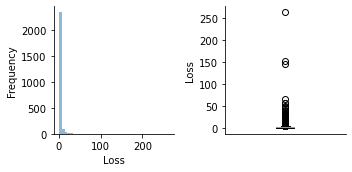

In [10]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(5, 2.5))
num_bins = 40
# the histogram of the data
n, bins, patches = axs[0].hist(danish, num_bins, alpha=0.5)
axs[1].boxplot(danish)
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Frequency")
axs[1].set_ylabel("Loss")
axs[1].set_xticks([])
# plt.show()
sns.despine()
plt.savefig("../Figures/hist_boxplot_danish_en.pdf")

## Importation of the fiting data

In [305]:
import pickle
single_model_df_import = pd.read_csv("../Data/Danish/danish_single_model_fit_.csv").drop(columns = ["Unnamed: 0"], axis = 1)
single_model_df_import["threshold_estimation"] = None
single_model_names = single_model_df_import["model"].values
selec = np.logical_or(np.logical_or(single_model_names == "Lognormal-Pareto", single_model_names == "Gamma-Pareto") ,  single_model_names == "Weibull-Pareto")
threshold_estimation = single_model_df_import["threshold_estimation"].values
threshold_estimation[selec] = "simultaneous"
single_model_df_import["threshold_estimation"] =  threshold_estimation
single_model_df_import["Body"] =  None
single_model_df_import["Tail"] =  None
single_model_df_import["Type"] =  None
with open('../Data/Danish/trace_danish_single_models.obj', 'rb') as fp:
    fit_single_dic_import = pickle.load(fp)
spliced_model_fixed_threshold_df_import = pd.read_csv("../Data/Danish/danish_spliced_models_fixed_threshold.csv").drop(columns = ["Unnamed: 0", "posterior_probability"], axis = 1)
spliced_model_fixed_threshold_df_import["threshold_estimation"] = "fixed"
with open('../Data/Danish/trace_danish_spliced_models_fixed_threshold.obj', 'rb') as fp:
    fit_spliced_fixed_threshold_dic_import = pickle.load(fp)
strip_model_names = pd.DataFrame([np.char.split(spliced_model_fixed_threshold_df_import["model"].values[k], sep = "_").tolist() for k in range(len(spliced_model_fixed_threshold_df_import))])
strip_model_names.columns = ["Body", "Tail", "Type"]
spliced_model_fixed_threshold_df_import = spliced_model_fixed_threshold_df_import.join(strip_model_names)

loss_model_df = pd.concat([single_model_df_import,spliced_model_fixed_threshold_df_import])
fit_loss_model_dic = {**fit_single_dic_import, **fit_spliced_fixed_threshold_dic_import}

loss_models = ["Log-Logistic", "Lomax", "Burr", "Exp", "Gamma", "Weibull", "Inverse-Gaussian", "Lognormal", "Inverse-Weibull", "Inverse-Gamma"]

for loss_model in loss_models:
    spliced_model_df_import = pd.read_csv("../Data/Danish/danish_splicing_model_fit_"+loss_model+".csv").drop(columns = ["Unnamed: 0", "posterior_probability"], axis = 1)
    spliced_model_df_import["threshold_estimation"] = "simultaneous"
    strip_model_names = pd.DataFrame([np.char.split(spliced_model_df_import["model"].values[k], sep = "_").tolist() for k in range(len(spliced_model_df_import))])
    strip_model_names.columns = ["Body", "Tail", "Type"]
    spliced_model_df_import = spliced_model_df_import.join(strip_model_names)

    loss_model_df = pd.concat([loss_model_df, spliced_model_df_import])
    with open("../Data/Danish/trace_danish_"+loss_model+".obj", 'rb') as fp:
        fit_spliced_dic_import = pickle.load(fp)

## Analysis of the composite models with free threshold 

### Goodness of fit comparisons

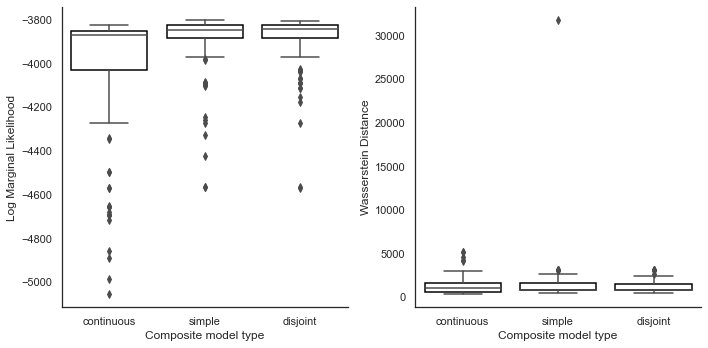

In [311]:
selec = np.logical_and(loss_model_df["Type"].values != None, loss_model_df["threshold_estimation"].values == "simultaneous")  
sub_df = loss_model_df.iloc[selec].reset_index(drop=True)
sns.set_theme(style="white")
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(10,5))
g = sns.boxplot(ax = axs[0], x="Type", y="log_marg", data=loss_model_df.iloc[selec])
g.set(xlabel="Composite model type", ylabel="Log Marginal Likelihood")
for i,box in enumerate(g.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')
g = sns.boxplot(ax = axs[1], x="Type", y="Wass_dist", data=loss_model_df.iloc[selec])
g.set(xlabel="Composite model type", ylabel="Wasserstein Distance")
for i,box in enumerate(g.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')
fig.tight_layout()
sns.despine()
plt.savefig("../Figures/boxplot_danish_log_marg_Wass_free_threshold.pdf")

### Combination of models comparisons

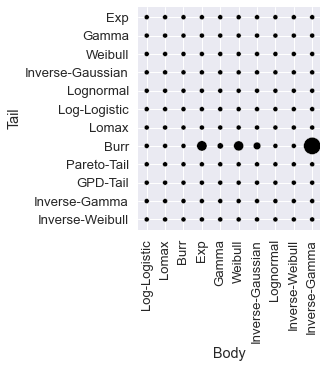

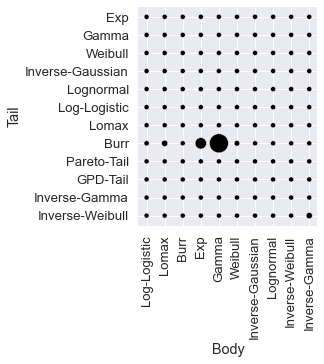

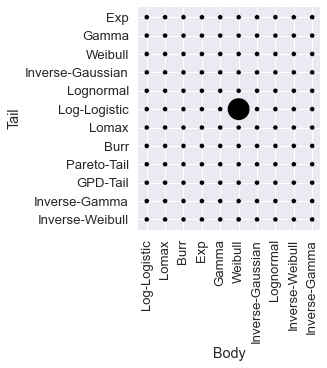

In [307]:
import seaborn as sns
sns.set_theme(style="whitegrid")

compo_model_types = ["disjoint", "simple", "continuous"]
sns.set(font_scale=1.2)
for compo_model_type in compo_model_types:

    s = np.logical_and(loss_model_df["Type"].values == compo_model_type, loss_model_df["threshold_estimation"].values == "simultaneous")  
    sub_df = loss_model_df.iloc[s].reset_index(drop=True)
    sub_df["w"] = np.exp(sub_df["log_marg"] - np.max(sub_df["log_marg"])) / np.sum(np.exp(sub_df["log_marg"] - np.max(sub_df["log_marg"]))) 
    criterium = "w"

    # Draw each cell as a scatter point with varying size and color
    g = sns.relplot( data=sub_df,
        x="Body", y="Tail", size=criterium, color = "black",
        height=5, sizes=(25, 500), size_norm=(0,1), aspect = 1
    )
    g._legend.remove()
    # # Tweak the figure to finalize
    g.set(xlabel="Body", ylabel="Tail", aspect="equal")
    g.despine(left=True, bottom=True)
    # g.ax.margins(.02)
    for label in g.ax.get_xticklabels():
        label.set_rotation(90)
    for artist in g.legend.legendHandles:
        artist.set_edgecolor(".7")
    # title
    fig.tight_layout()
    new_title = 'Model weights'
    g._legend.set_title(new_title)
    plt.savefig("../../SMCLoMo/Figures/model_grid_danish_w_"+compo_model_type+"_free_threshold.pdf", bbox_inches='tight')


### Value of the threshold

In [335]:
s =  np.logical_and(loss_model_df["threshold_estimation"].values == "simultaneous", loss_model_df["Body"].values != None)
sub_df = loss_model_df.iloc[s].reset_index(drop=True)
sns.set_theme(style="white")
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(10,5))
compo_model_types = ["disj"]
for 
g = sns.histplot(ax = axs[0], x="Type", y="log_marg", data=loss_model_df.iloc[selec])
g.set(xlabel="Composite model type", ylabel="Log Marginal Likelihood")
for i,box in enumerate(g.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')
g = sns.boxplot(ax = axs[1], x="Type", y="Wass_dist", data=loss_model_df.iloc[selec])
g.set(xlabel="Composite model type", ylabel="Wasserstein Distance")
for i,box in enumerate(g.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')
fig.tight_layout()
sns.despine()

0       99
1      115
2      100
3       99
4      115
      ... 
355    115
356    100
357     99
358    115
359    100
Name: Type, Length: 360, dtype: int64

C:\Users\pierr\anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
C:\Users\pierr\anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


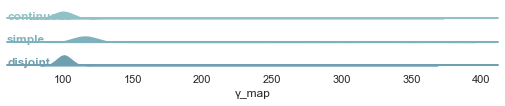

In [338]:
s =  np.logical_and(loss_model_df["threshold_estimation"].values == "simultaneous", loss_model_df["Body"].values != None)
sub_df = loss_model_df.iloc[s].reset_index(drop=True)
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

m = sub_df.Type.astype(str).str[0].map(ord)
sub_df["γ_map"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(sub_df, row="Type", hue="Type", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "γ_map",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "γ_map", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "γ_map")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=1)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

In [315]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
df
# m = df.g.map(ord)
# df["x"] += m

# # Initialize the FacetGrid object
# pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
# g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# # Draw the densities in a few steps
# g.map(sns.kdeplot, "x",
#       bw_adjust=.5, clip_on=False,
#       fill=True, alpha=1, linewidth=1.5)
# g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# # passing color=None to refline() uses the hue mapping
# g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# # Define and use a simple function to label the plot in axes coordinates
# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(0, .2, label, fontweight="bold", color=color,
#             ha="left", va="center", transform=ax.transAxes)


# g.map(label, "x")

# # Set the subplots to overlap
# g.figure.subplots_adjust(hspace=-.25)

# # Remove axes details that don't play well with overlap
# g.set_titles("")
# g.set(yticks=[], ylabel="")
# g.despine(bottom=True, left=True)

,x,g
0,-0.961877,A
1,0.147050,B
2,-0.629989,C
3,0.791019,D
4,1.583534,E
...,...,...
495,-0.641978,F
496,1.212877,G
497,-1.525753,H
498,0.251022,I


<AxesSubplot:xlabel='γ_map', ylabel='Count'>

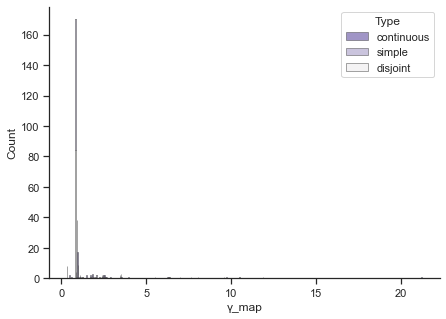

In [120]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")

diamonds = sns.load_dataset("diamonds")

f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

sns.histplot(
    loss_model_df.iloc[selec].reset_index(drop=True),
    x="γ_map", hue="Type",
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
)
# ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
# ax.set_xticks([0, 1, 10])

C:\Users\pierr\anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
C:\Users\pierr\anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


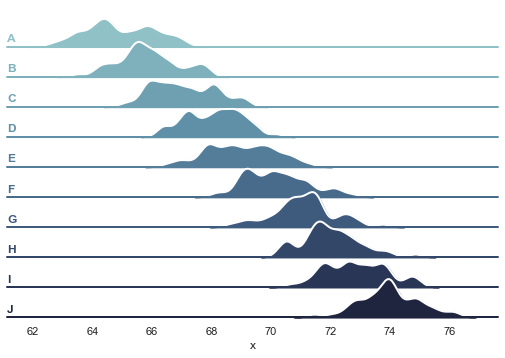

In [121]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = loss_model_df.iloc[selec].reset_index(drop=True)
m = df.Type.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

In [100]:
loss_model_df[loss_model_df["γ_map"].values > 50]
X = danish.values
np.mean(X > 50)

0.0028089887640449437